# Study on playtime of Steam Games

Done by:  
Lim Song Wei, Greg - U2120517G  
Charles Chan - U2121762F  
Leow Wei Jie - U2122666J  



### Motivation
Steam makes up 75% of the PC game distribution market share  
Steam has \$4.3 billion of sales in 2017  
The gaming industry is expected to grow to \$256.97 billion  
Therefore, there is strong incentives for developer to target profitable aspects of the industry.

### Dataset
The dateset was retrived from:
https://www.kaggle.com/datasets/nikdavis/steam-store-games/.  
Which was retrieved from Steam and SteamSpy APIs  
It includes games till April 2019.
The data set contains 27033 games.



## Contents
1. [Data Cleaning](#Cleaning)
2. [Data Preprocessing](#Data_preprocessing)
3. [Data Analysis](#Analysis)
4. [Question & Data Prediction](#Question)
5. [Conclusion](#Conclusion)

<!-- 
<a href='#Data_preprocessing'>Data Preprocessing</a>  
<a href='#Analysis'>Data Analysis</a>  
<a href='#Question'>Question and Predictions</a>  
<a href='#Conclusion'>Conclusion</a>-->

'>Data Cleaning</a>  
<a href='#Data_preprocessing'>Data Preprocessing</a>  
<a href='#Analysis'>Data Analysis</a>  
<a href='#Question'>Question and Predictions</a>  
<a href='#Conclusion'>Conclusion</a>-->

### Importing Dependencies

In [1]:
import re
import os
import itertools
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from ast import literal_eval
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.metrics.pairwise import cosine_similarity
import math

In [2]:
# import the datasets into dataframes
gameDF = pd.read_csv("datasets/steam.csv")
descDF = pd.read_csv("datasets/steam_description_data.csv")
reqDF = pd.read_csv("datasets/steam_requirements_data.csv")
tagDF = pd.read_csv("datasets/steamspy_tag_data.csv")

<a id='Cleaning'></a>

### Cleaning and merging game requirments with gameDF
We decided to use RAM as a gauge of games requirements as it was the most availible data for most games and reflective of the actual requirements.

In [3]:
# Looking at what values in reqDF are useful
reqDF.sample(n=5)

,steam_appid,pc_requirements,mac_requirements,linux_requirements,minimum,recommended
19803,781990,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],[],OS: Windows 7 Processor: 2Ghz Memory: 256 MB R...,NaN
1551,224700,{'minimum': '<p><strong>Minimum:</strong></p>\...,[],[],OS:Windows XP SP3/Vista/7Processor:1.4+GHzMemo...,Graphics:512+MB
15828,671750,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],[],"OS: XP SP 3 Processor: 2,5 GHz Memory: 256 MB ...",OS: Windows 7 Processor: 2.5 GHz Memory: 512 M...
14478,628890,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],[],"OS: Windows® 10, Windows® 8.1, Windows® 7 Japa...","OS: Windows® 10, Windows® 8.1, Windows® 7 Japa..."
2718,283350,{'minimum': '<strong>Minimum:</strong><br><ul ...,[],[],OS: Windows XP/Vista/7 Processor: P 226 or Bet...,NaN


It is Obeserved that there are many null/empty value in "mac_requirements", "linux_requirements", "recommended".
It is also obseved that "minimum" is a value derieved from minimum requirements in "pc_requirements".

In [4]:
reqDF = reqDF.drop(columns=["mac_requirements", "linux_requirements", "recommended", "pc_requirements"])
reqDF["ram"] = reqDF["minimum"].str.extract(r'(?:Memory):?\s?([0-9]+\s?[gGmM][bB])')
print("Missing Count:", str(reqDF["ram"].isna().sum()))

def mbgbtoint(numUnit):
    numUnit = str(numUnit).replace(" ","").lower()
    #print(numUnit)
    m=re.findall("([0-9]+)([mg])b", numUnit)
    if len(m)==0: return
    m=np.array(m)
    #print(m)
    [[t,u]] = m
    if u=='g':
        return int(t)*1024
    elif u=='m':
        return int(t)


reqDF["ram"] = reqDF["ram"].apply(mbgbtoint)
print("Missing: "+ str(reqDF["ram"].isna().sum()/reqDF["ram"].count()))

# fill with median as ram is an exponential scale
reqDF['ram'] = reqDF['ram'].fillna(reqDF['ram'].median())
print("\nAfter filling with median")
print("Missing Count : "+ str(reqDF["ram"].isna().sum()))
reqDF=reqDF.drop(columns=["minimum"])

Missing Count: 2682
Missing: 0.10886065673580388

After filling with median
Missing Count : 0


In [5]:
gameDF = gameDF.merge(reqDF, left_on="appid", right_on="steam_appid").drop(columns=["steam_appid"])

## Data Cleaning


The data set is already quite clean, but we can make a few adjustments in order to make our data analysis easier. We add some new metrics, like total reviews and positive review percentage, and change the release dates to datetime format, and separate out the date and year of release as well. We will also convert the ranges of the owners column into an integer, using its lower bound. This gives us a rough approximation of how many people own the game on Steam.

In [7]:
# combine positive and negative review numbers for the total
gameDF = gameDF.assign(**{'overall_reviews':gameDF.positive_ratings + gameDF.negative_ratings})
# percentage of positive reviews
gameDF = gameDF.assign(**{'positive_percentage':gameDF.positive_ratings / gameDF.overall_reviews})

# boolean to show if a game is free-to-play or not
gameDF = gameDF.assign(**{'is_free':gameDF.price == 0})

# changes the release dates to datetime objects to make working with easier
gameDF['release_date'] = gameDF['release_date'].astype('datetime64[ns]')
# add a release year column
gameDF['release_year'] = gameDF['release_date'].apply(lambda x: x.year)

# converts the ranges of owners into an integer approximation instead, using the lower bound
gameDF['owners'] = gameDF['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

<a id='Data_preprocessing'></a>

## Data Preprocessing


This section of the preprocessing does a lot. First, it takes care of the categorical variables in the rows, the game categories and tags,  which are in the form of lists. Following the outline of one-hot encoding, new columns are created for each category which will hold boolean values indicating membership. Created lists of the final tags and categories that each entry will use, and make a count of each row's genre and category membership for later use. Since the non-game genres were removed from the final list, we can prune non-games from the dataset by removing entries that do not have membership to any genre. 

In [8]:
def get_unique(series):
    """Get unique values from a Pandas series containing semi-colon delimited strings."""
    return set(list(itertools.chain(*series.apply(lambda x: [c for c in x.split(';')]))))

category_colummns = get_unique(gameDF["categories"])
genre_columns = get_unique(gameDF["genres"])

# filter out the columns we want and add them to the dataFrame (by re-defining the columns themselves)

# THESE ARE THE CATEGORY COLUMNS THAT WILL BE ADDED TO THE DATAFRAME
category_columns = ['Local Multi-Player', 'Multi-player', 'Online Multi-Player', 'Single-player', 'MMO', 
    'Steam Cloud', 'Online Co-op', 'VR Support', 'Steam Workshop', 'Full controller support', 'Local Co-op', 
    'Partial Controller Support', 'Steam Trading Cards', 'In-App Purchases', 'Mods', 'Co-op']
# THESE ARE THE GENRE COLUMNS THAT WILL BE ADDED TO THE DATAFRAME
genre_columns = ['Strategy', 'Racing', 'Massively Multiplayer', 'Free to Play', 'RPG', 
    'Early Access', 'Casual', 'Sports', 'Indie', 'Action', 'Simulation', 'Adventure']

gen_col_names = []
cat_col_names = []

# create and insert a new column for each category in the list
# boolean values indicate membership to the categories (one-hot encoding)
for col in sorted(category_columns):
    col_name = re.sub(r'[\s\-\/]', '_', col.lower())
    col_name = re.sub(r'[()]', '', col_name)
    cat_col_names.append(col_name)
    gameDF[col_name] = gameDF['categories'].apply(lambda x: 1 if col in x.split(';') else 0)

# create new columns for each genre
for col in sorted(genre_columns):
    col_name = col.lower().replace('&', 'and').replace(' ', '_')
    gen_col_names.append(col_name)
    gameDF[col_name] = gameDF['genres'].apply(lambda x: 1 if col in x.split(';') else 0)

print("Genre column names: ", gen_col_names)
print("Category column names: ", cat_col_names)

# these sums will be useful in looking at the distributions each game's tags
gen_sum = gameDF[gen_col_names].sum(axis=1)
cat_sum = gameDF[cat_col_names].sum(axis=1)

print("sum of genres: \n", gen_sum)
print("sum of categories: \n", cat_sum)

# remove entries which do not fall into any of the predefined genres (sum of all genre columns = 0)
gameDF = gameDF[gen_sum > 0].copy()
# drop the replaced category and tag columns from the dataFrame
gameDF = gameDF.drop(['categories', 'steamspy_tags'], axis=1)

print('Verify no missing values:')
print(gameDF.isnull().sum().value_counts())    

Genre column names:  ['action', 'adventure', 'casual', 'early_access', 'free_to_play', 'indie', 'massively_multiplayer', 'rpg', 'racing', 'simulation', 'sports', 'strategy']
Category column names:  ['co_op', 'full_controller_support', 'in_app_purchases', 'local_co_op', 'local_multi_player', 'mmo', 'mods', 'multi_player', 'online_co_op', 'online_multi_player', 'partial_controller_support', 'single_player', 'steam_cloud', 'steam_trading_cards', 'steam_workshop', 'vr_support']
sum of genres: 
 0        1
1        1
2        1
3        1
4        1
        ..
27057    3
27058    3
27059    3
27060    3
27061    3
Length: 27062, dtype: int64
sum of categories: 
 0        3
1        3
2        1
3        3
4        2
        ..
27057    1
27058    1
27059    5
27060    2
27061    2
Length: 27062, dtype: int64
Verify no missing values:
0    49
dtype: int64


Now, we have two series listing each row's genre and category count, so we append it to the dataset.

In [9]:
# assign these new counts to the dataframe, so we can chart it
gameDF['gen_sum'] = gen_sum
gameDF['cat_sum'] = cat_sum

In [10]:
gameDF.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,genres,achievements,...,free_to_play,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy,gen_sum,cat_sum
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,1,3
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,1,3
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,1,1
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,1,3
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,0,0,1,2


<a id='Analysis'></a>

## Analysis and Exploration


### Releases

Since we have formatted our release dates into datetime objects, we can apply max and min methods to them and find out when, in the context of this dataset, when the first and last releases were.

In [11]:
print('The first game was released on {}.'.format(gameDF.release_date.min().strftime("%d %B %Y")))
print('The last game was released on {}.'.format(gameDF.release_date.max().strftime("%d %B %Y")))

The first game was released on 30 June 1997.
The last game was released on 01 May 2019.


The dataset capture ends around the middle of 2019.

In [12]:
years = gameDF.groupby(gameDF.release_date.dt.year.rename('release_year'))\
    .agg('count').appid.rename('count')

years = years[years.index > 2006]
years = years[2018 > years.index]

years = years.to_frame().reset_index()

fig = px.histogram(years, x="release_year", y="count", title="Releases by Year",
     color_discrete_sequence=['deeppink'], labels={'count':'Releases', 'release_year':'Release Year'}, nbins=12)
fig.show()

Note that years leading up to 2007 was excluded due to exceedingly low releases on those years, and the year 2018 was excluded as the data was captured in the middle of that year. The number of releases have gone up significantly year by year. 

### Genres and Categories

In [13]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Genres", "Categories"))

hist1 = go.Histogram(x=gameDF['gen_sum'], name='No. of Genres')
hist2 = go.Histogram(x=gameDF['cat_sum'], name='No. of Categories')

fig.add_trace(hist1, row=1, col=1)
fig.add_trace(hist2, row=1, col=2)

fig.show()

From the data, it can be observed that most games have 2 to 3 genres, suggesting that the games frequently have overlapping genres, and that genres will often be associated with a few others. The same can be said for game categories, with most games having 1-2 of them.

We now will sum up all the occurrences of genres and categories across all games in the dataset and create a count plot.

In [14]:
genre_counts = gameDF[gen_col_names].sum()
cat_counts = gameDF[cat_col_names].sum()

# converting to dataframe to make it easier for plotly charts
genre_counts = genre_counts.to_frame().reset_index()
genre_counts = genre_counts.rename(columns={0 : "count", "index" : "genre"})

cat_counts = cat_counts.to_frame().reset_index()
cat_counts = cat_counts.rename(columns={0 : "count", "index" : "category"})

In [15]:
fig = px.histogram(genre_counts, x="count", y="genre", title="Frequency of Genres",
     color_discrete_sequence=['indianred']).update_yaxes(categoryorder="total ascending")
fig.show()

Of all the main genre tags in the Steam listings, games that have the Indie genre seem to have the highest frequency. However, despite being labeled as a genre by Steam, independent games do not have a strong enough basis to be called genres by themselves, as indie just means games that are made by small or single-man parties, and not under a large publisher. Indie games hence are a segment of games, and would have genres of their own as well, explaining the majority of games having 2 or more genres in their listings. 

In [16]:
fig = px.histogram(cat_counts, x="count", y="category", title="Frequency of Categories",
     color_discrete_sequence=['indigo']).update_yaxes(categoryorder="total ascending")
fig.show()

### Indies

In [17]:
# breaking down the amount of indie and non-indie releases by year.
# can be modified for other categories to compare to all releases of the year.
df = gameDF.copy()

years = []
indies = []
all_releases = []

for year in sorted(df['release_year'].unique()):
    if year < 2006 or year > 2018:
        continue
    
    # subset dataframe by year
    year_df = df[df.release_year == year]
    
    # calculate total releases, and those that are indie
    total_indie = year_df[year_df.indie == 1].shape[0]
    total_releases = year_df[year_df == 1].shape[0]
    
    years.append(year)
    indies.append(total_indie)
    all_releases.append(total_releases)
    
indies_df = pd.DataFrame(zip(years, indies, all_releases), 
                         columns=['year', 'Indies', 'All_Releases'])

indies_df.head()

,year,Indies,All_Releases
0,2006,8,47
1,2007,3,92
2,2008,23,144
3,2009,59,305
4,2010,64,238


In [18]:
fig = px.bar(indies_df, x="year", y=["All_Releases", "Indies"], title="Indie releases compared to total releases")
fig.show()

When Steam Greenlight was introduced in 2012 to provide quality control and highlight independent games, the amount of indie releases jumped to account around half of the total releases of that year. When Valve sunset Greenlight to replace it with Steam Direct in 2017 as an affordable publishing platform, more than half of all games released that year were indie releases. 

In [19]:
indies_pie = gameDF.loc[gameDF['indie'] == 1]
indies_pie = indies_pie['genres'].value_counts()
indies_pie = indies_pie.to_frame().reset_index()
indies_pie = indies_pie[indies_pie['genres'] > 100]

fig = px.pie(indies_pie, values='genres', names='index', title='Indie Game genre pie')
fig.show()

In [20]:
eda_df = gameDF.loc[gameDF['indie'] == 1]
eda_df = pd.DataFrame(zip(eda_df['action'], eda_df['adventure'], eda_df['casual'], eda_df['early_access'],
                        eda_df['free_to_play'], eda_df['massively_multiplayer'], eda_df['rpg'], eda_df['racing'],
                        eda_df['sports'], eda_df['strategy'], eda_df['indie']
                         ),
                      columns=['action', 'adventure', 'casual', 'early_access', 'free_to_play', 'massively_multiplayer',
                      'rpg', 'racing', 'sports', 'strategy', 'indie'])


In [21]:
eda_df.head()

,action,adventure,casual,early_access,free_to_play,massively_multiplayer,rpg,racing,sports,strategy,indie
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,1,0,0,0,1


The genres are in the form of a list within one cell, making it hard to use as categorical data. As such, it is converted to one-hot encoding, where every column has a separate genre, with a boolean value representing membership.

In [22]:
dfCorr = eda_df.corr()
fig = ff.create_annotated_heatmap(
    z=dfCorr.values,
    x=list(dfCorr.columns),
    y=list(dfCorr.index),
    colorscale=px.colors.diverging.RdBu,
    annotation_text=dfCorr.round(2).values,
    showscale=True, reversescale=True)

fig.show()

Correlations made between distinct genres do not seem to be extremely strong. Perhaps we can look at the categories or tags instead. Included in the dataset is the SteamSpy tags of each game, nominated for each game via a vote. The tags are much more granular and descriptive, and as such, there are 372 possible tags for each game.

Each tag column has a numerical value representing the number of votes for the relavance of the tag towards each game. A higher number will mean a stronger relation to that tag.

### Analysis of SteamSpy tags (Clustering)

In [23]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import networkx as nx

In [24]:
tagDF2 = tagDF.copy()
tagDF2 = tagDF2.loc[:,tagDF2.max() > 4500]
tagDF2.info()
tagDF2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29022 entries, 0 to 29021
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   appid                 29022 non-null  int64
 1   2d                    29022 non-null  int64
 2   action                29022 non-null  int64
 3   adventure             29022 non-null  int64
 4   atmospheric           29022 non-null  int64
 5   building              29022 non-null  int64
 6   choices_matter        29022 non-null  int64
 7   class_based           29022 non-null  int64
 8   co_op                 29022 non-null  int64
 9   comedy                29022 non-null  int64
 10  competitive           29022 non-null  int64
 11  crafting              29022 non-null  int64
 12  crime                 29022 non-null  int64
 13  dark_fantasy          29022 non-null  int64
 14  dinosaurs             29022 non-null  int64
 15  driving               29022 non-null  int64
 16  expl

,appid,2d,action,adventure,atmospheric,building,choices_matter,class_based,co_op,comedy,...,strategy,survival,tactical,team_based,third_person,third_person_shooter,trading,war,zombies,e_sports
0,10,0,2681,0,0,0,0,0,0,0,...,329,192,734,943,0,0,0,0,0,550
1,20,0,208,15,0,0,0,124,62,0,...,0,0,0,115,0,0,0,0,0,0
2,30,0,99,0,0,0,0,55,12,0,...,0,0,14,79,0,0,0,80,0,0
3,40,0,85,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,50,0,211,87,73,0,0,0,27,0,...,0,0,0,0,0,0,0,0,0,0


There are 372 columns of tags, which is a bit much to work with, so we will drop columns based on their max value across all rows, which means only the more popular tags overall will be retained for analysis. Columns with less than 4500 across them are dropped, removing the less-common and applicable tags. We have now a more compact and useful  dataframe, with 55 of the most common SteamSpy tags.

In [25]:
topTags = pd.DataFrame(tagDF2.apply(lambda x:list(tagDF2.columns[np.array(x).argsort()[::-1][:10]]), 
    axis=1).astype('string')
,  columns=['Top10'])

topTags = pd.concat([topTags, tagDF2[['appid']]], axis=1)
topTags.head()

,Top10,appid
0,"['action', 'fps', 'multiplayer', 'shooter', 't...",10
1,"['action', 'fps', 'multiplayer', 'shooter', 'c...",20
2,"['fps', 'multiplayer', 'action', 'shooter', 'w...",30
3,"['action', 'fps', 'multiplayer', 'shooter', 'a...",40
4,"['fps', 'action', 'singleplayer', 'shooter', '...",50


Since each row (game) has tags (columns) with a numerical value signifying the strength of their association with that tag, we can sort and extract the top 10 tags per game. This might come in useful for further analysis, but instead we try and visualise the relationship between tags.

Let's try and conduct clustering based on similarity or distance of tags in the SteamSpy dataset. The rows in that dataset represent games, while there are 55 columns of tags, with the numerical data representing the number of votes for that tag, suggesting the tag's strength of association with the game. We transpose the dataframe, so that we have 55 rows.

Then, use pairwise distance as a metric for each tag, and create a 55 by 55 distance matrix for the tags. After that, use that matrix as input for a heatmap, where lower (distance) values will suggest a stronger connection between tags.

In [26]:
tagDF3 = tagDF2.T
tagDF3 = tagDF3.drop('appid')

pairwise = pd.DataFrame(
    squareform(pdist(tagDF3)),
    columns = tagDF3.index,
    index = tagDF3.index
)
pairwise.head()

,2d,action,adventure,atmospheric,building,choices_matter,class_based,co_op,comedy,competitive,...,strategy,survival,tactical,team_based,third_person,third_person_shooter,trading,war,zombies,e_sports
2d,0.000000,32359.237661,20994.969016,15480.386462,13116.869329,9486.947296,10161.168486,20027.357339,12958.115951,15675.686492,...,16043.306548,27689.882846,14999.015801,17755.834478,18376.483396,14570.330676,10127.786382,10960.677169,19529.577748,12630.885796
action,32359.237661,0.000000,23370.065126,25783.031222,31787.519957,33097.466625,31314.707615,19376.999768,28189.821479,27951.642510,...,30159.414202,34116.814828,27868.604038,26815.160376,25129.402977,26760.485123,30053.330315,30150.761417,31900.717312,29452.415419
adventure,20994.969016,23370.065126,0.000000,13488.497878,19589.182704,22275.326552,22585.585558,18235.830664,19707.012483,25546.680234,...,25368.958177,23780.860203,24850.624680,26651.611246,17374.479043,19493.719604,22567.836117,22798.357397,22453.960208,23800.161974
atmospheric,15480.386462,25783.031222,13488.497878,0.000000,18525.657073,15120.462295,15684.732640,18576.552667,14988.820234,19648.436935,...,19673.629101,27044.628099,18796.294528,21187.666578,11401.944966,13135.294096,15674.498397,16005.174070,19892.495620,17392.880469
building,13116.869329,31787.519957,19589.182704,18525.657073,0.000000,16005.874234,14778.085600,19010.838040,15309.064112,19018.509353,...,18958.327563,24502.654407,18461.176615,20748.226310,21143.848018,17990.707685,14762.541312,15376.155859,21840.402011,16581.251491


In [27]:
fig = px.imshow(pairwise.values, x=pairwise.columns, y=pairwise.index, color_continuous_scale='Viridis', aspect="auto")
fig.update_layout(
    autosize=True,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=2
    ),
    paper_bgcolor="LightBlue",
)
fig.show()

From the heatmap of distances between tags, it is clear that the free-to-play, multiplayer, open-world, survival and action tags have drastically more representation than the others, skewing the distance data. We can use the cosine distance metric to normalise the distances somewhat, for a better heatmap.

In [28]:
pairwise2 = pd.DataFrame(
    squareform(pdist(tagDF3, metric='cosine')),
    columns = tagDF3.index,
    index = tagDF3.index
)

fig = px.imshow(pairwise2.values, x=pairwise2.columns, y=pairwise2.index, color_continuous_scale='viridis', aspect="auto")
fig.update_layout(
    autosize=True,
    width=1000,
    height=800,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=2
    ),
    paper_bgcolor="LightBlue",
)
fig.show()

Since we have a pair distance matrix to show us which tags are strongly associated with each other, we should use Agglomerative Hierarchical Clustering from the scikit-learn module to further visualise the associations.
Hierarchical clustering has the benefit of not having to pre-define cluster sizes like K-means clustering for example. Agglomerative clustering is a type of bottom-up method, where the closest pairs of clusters will be linked until a single large cluster is left.

The distance information is used as input in a linkage function (we will use Ward's method) to generate clusters. We will then make a dendrogram to visualise this clustering.

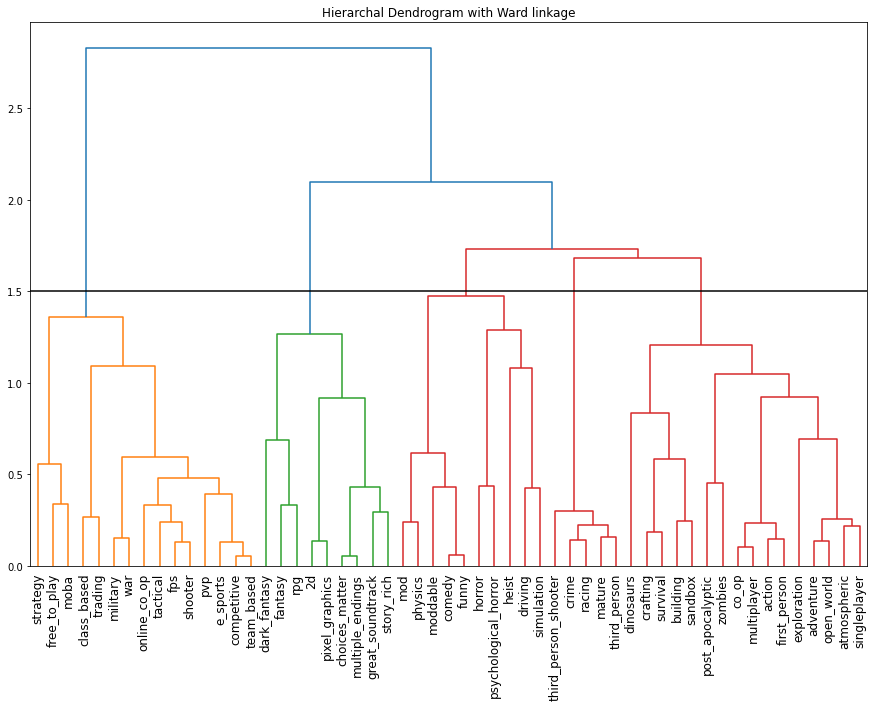

In [29]:
# condense the distance matrix
condensedPairwise = squareform(pairwise2)
# getting labels for the dendrogram from the dataframe index
labels = list(tagDF3.index.values)

plt.figure(figsize =(15, 10))
plt.title('Hierarchal Dendrogram with Ward linkage')
Dendrogram = shc.dendrogram((shc.linkage(condensedPairwise, method ='ward')), labels=labels, leaf_font_size=12.)

# threshold for dendrogram cut
cut = 1.5
plt.axhline(y=cut, c='k')

Hierarchical clustering does not specify where the clusters are, so the dendrogram must be cut at a certain height or threshold to form clusters.
Based on our selected threshold of 1.5, we have 5 clusters in our Hierarchal Agglomerative Clustering (HAC) of the pruned SteamSpy tags dataset, as visualised by the dendrogram.

<img src='5clusters.png' width="600" height="500">

**Observations:**

Cluster 1 - Predominantly online multiplayer games in this cluster, with a focus on team-based competitive genres, like tactical shooters and class-based MOBAs. Free-to-play and trading are a few notable features.

Cluster 2 - This cluster seems to hold singleplayer role-playing games, or other games with a strong narrative and atmosphere. 2D games and games with pixel graphics are in this cluster due to their association with traditional JRPGs.

Cluster 3 - A much more broad and unfocused cluster, but three branches can be observed. The first consists of physics-based, moddable and often comedic games, while the second contains horror games. The third consists of simulation games. A common thread with these tags seem to be emergent, unscripted, experience-based games.

Cluster 4 - This cluster seems to contain games with cars and crime as tags, suggesting games along Grand Theft Auto's style of presentation.

Cluster 5 - The largest cluster by numbers of tags, with the left sub-cluster containing sandbox survival games with crafting, and the right containing open-world games with exploration. The common feature appears to be non-linear, sandbox games with crafting and exploration heavily featured.

In [30]:
topTags['Top10'] = topTags['Top10'].apply(literal_eval)

cluster1 = ['strategy', 'free_to_play', 'moba', 'class_based', 'trading', 'military', 'war', 'online_co_op',
        'tactical', 'fps', 'shooter', 'pvp', 'e_sports', 'competitive', 'team_based']
cluster2 = ['dark_fantasy', 'fantasy', 'rpg', '2d', 'pixel_graphics', 'choices_matter', 'multiple_endings',
        'great_soundtrack', 'story_rich']
cluster3 = ['mod', 'physics', 'moddable', 'comedy', 'funny', 'horror', 'psychological_horror', 'heist',
        'driving', 'simulation']
cluster4 = ['third_person_shooter', 'crime', 'racing', 'mature', 'third_person']
cluster5 = ['dinosaurs', 'crafting', 'survival', 'building', 'sandbox', 'post_apocalyptic', 'zombies',
        'co_op', 'multiplayer', 'action', 'first_person', 'exploration', 'adventure', 'open_world',
        'atmospheric', 'singleplayer']


tagsDict = topTags.to_dict('records')
# print(type(tagsDict[1]['Top10']))

for row in tagsDict:
    tempTags = row['Top10']
    tempL = []

    tempL.append(len(set(tempTags).intersection(cluster1)))
    tempL.append(len(set(tempTags).intersection(cluster2)))
    tempL.append(len(set(tempTags).intersection(cluster3)))
    tempL.append(len(set(tempTags).intersection(cluster4)))
    tempL.append(len(set(tempTags).intersection(cluster5)))
    
    maxV = __builtin__.max(tempL)
    maxIndex = tempL.index(maxV)
    row['cluster'] = "cluster_{}".format(maxIndex+1)
    tempL.clear()

tagsDict = pd.DataFrame.from_records(tagsDict)

gameDF = pd.merge(left=gameDF, right=tagsDict, left_on='appid', right_on='appid')
gameDF.head()


,appid,name,release_date,english,developer,publisher,platforms,required_age,genres,achievements,...,massively_multiplayer,rpg,racing,simulation,sports,strategy,gen_sum,cat_sum,Top10,cluster
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,1,3,"[action, fps, multiplayer, shooter, team_based...",cluster_1
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,1,3,"[action, fps, multiplayer, shooter, class_base...",cluster_1
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,1,1,"[fps, multiplayer, action, shooter, war, team_...",cluster_1
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,1,3,"[action, fps, multiplayer, shooter, appid, fir...",cluster_5
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Action,0,...,0,0,0,0,0,0,1,2,"[fps, action, singleplayer, shooter, first_per...",cluster_5


In [32]:
gameDF_testing = gameDF[gameDF.average_playtime != 0]
numDF_testing = gameDF_testing[["average_playtime", "positive_ratings", "negative_ratings", 
        "price", "overall_reviews", "positive_percentage", "owners", "cluster"]]

df_dummies = pd.get_dummies(numDF_testing['cluster'])
df_new = pd.concat([numDF_testing, df_dummies], axis=1)
del df_new['cluster']
df_new.head()

,average_playtime,positive_ratings,negative_ratings,price,overall_reviews,positive_percentage,owners,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5
0,17612,124534,3339,7.19,127873,0.973888,10000000,1,0,0,0,0
1,277,3318,633,3.99,3951,0.839787,5000000,1,0,0,0,0
2,187,3416,398,3.99,3814,0.895648,5000000,1,0,0,0,0
3,258,1273,267,3.99,1540,0.826623,5000000,0,0,0,0,1
4,624,5250,288,3.99,5538,0.947996,5000000,0,0,0,0,1


<AxesSubplot:>

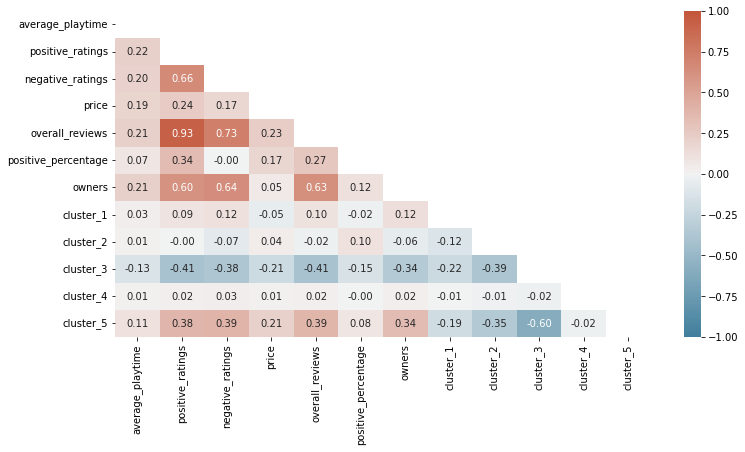

In [33]:
corrTest = df_new.corr(method='kendall')
mask = np.triu(np.ones_like(corrTest, dtype=bool))
cmap = sb.diverging_palette(230, 20, as_cmap=True)

f = plt.figure(figsize=(12, 6))
sb.heatmap(corrTest, mask=mask, cmap=cmap, vmin = -1, vmax = 1, annot = True, fmt = ".2f")

Even after adding each game's cluster as dummy variables, the correlation with the other properties is not great, suggesting that game and genre tags have less bearing on aspects such as reviews and playtime. This is perhaps due to the noisiness of the cluster data, and thus a higher weightage could be placed on the correlation values. 

Clustering has limited applicability in predictions, as it is not classification. It however can be used to group data for further analysis and observation work.


Of certain note is the how Cluster 3 and Cluster 5's correlations with other variables seem to be the inverse of one another. They also have the strongest negative correlation of -0.60. As Kendall rank correlation coefficient measures the strength of dependance between variables, it suggests that there is a strong amount of mutual exclusivity between Clusters 3 and 5.

It could then be possible to state that if games belonging to Cluster 5 have a higher average ownership and price, the opposite would be true for games belonging to Cluster 3.

In [56]:
os.makedirs('deepnote_exports/', exist_ok=True)  
gameDF.to_csv('deepnote_exports/gameDF_modified.csv')  
tagDF2.to_csv('deepnote_exports/tagDF_modified.csv')
pairwise2.to_csv('deepnote_exports/pairwiseMatrix.csv') 
topTags.to_csv('deepnote_exports/topTags_modified.csv')

<a id='Question'></a>

## Question: What genres and categories of games should developers target to increase their game’s average playtime? 
According to 
https://pubsonline.informs.org/doi/epdf/10.1287/isre.2019.0839
Play-time is correlated to profit. As profits and revernue are companies secrets, we decided to use playtime as a gauge for how well a game performed.

To answer the question, we have to first take a look the spread of `average_playtime`.
We decided to use the mean as the varible to predict, instead of median, as:
- It has a wider distribution 
- Mean is more reflective to the total hours played (mean*owners)

In [34]:
# The main data set to be use for training/validation and testing
dataDF = gameDF.drop(columns=['appid', 'release_year', 'positive_ratings','negative_ratings','overall_reviews','owners','median_playtime'])
# We decided to obmit ratings, and owners as these are not known until after the game is realeased

### Analysis: average_playtime
We took a look at the distribution of `average_playtime` and noticed that it was extremely skewed.

<AxesSubplot:title={'center':'Natural log transformed Excluding 0'}, xlabel='average_playtime', ylabel='Density'>

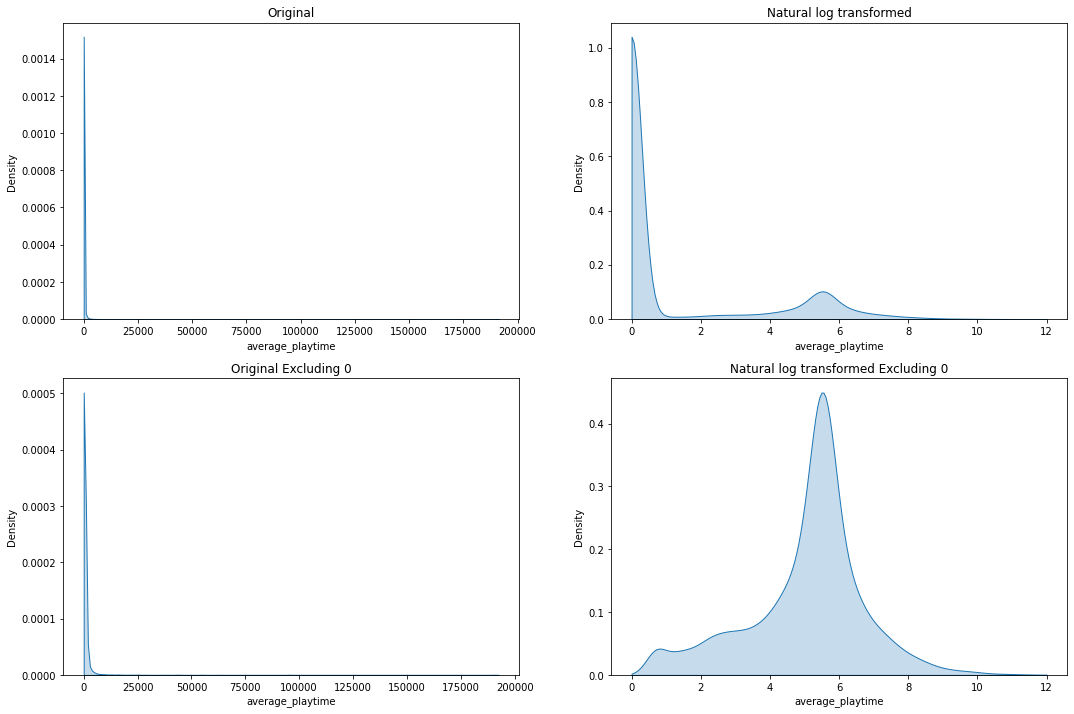

In [35]:
dataDFno0 = dataDF[dataDF.average_playtime != 0]

fig, axes = plt.subplots(2,2, figsize=(18, 12))

axes[0][0].set_title('Original')
sb.kdeplot(ax=axes[0,0], data=dataDF.average_playtime, clip=(0.0, 999999), fill=True)

axes[0][1].set_title('Natural log transformed')
sb.kdeplot(ax=axes[0,1], data=np.log(dataDF.average_playtime+1), clip=(0.0, 12), fill=True)

axes[1][0].set_title('Original Excluding 0')
sb.kdeplot(ax=axes[1,0], data=dataDFno0.average_playtime, clip=(0.0, 999999), fill=True)

axes[1][1].set_title('Natural log transformed Excluding 0')
sb.kdeplot(ax=axes[1,1], data=np.log(dataDFno0.average_playtime+1), clip=(0.0, 12), fill=True)

In [36]:
dataDF.average_playtime.describe()

# Logarithimic transformation
dataDF["average_playtime"] = np.log(dataDF.average_playtime+1)

As shown above by the graph and by using `.describe()` on **average_playtime**, the data is heavily imbalanced as the majority of the data is 0. as the 25, 50, & 75 percentile are all 0. 

From this we decided to use the natural log transformation of the average_playtime.
Even though removing 0 datas from `average_playtime` made our distribution normal, it was a significant portion of out data set. Hence, the 0 datas were not excluded, resulting in a distribution as shown on the top right as removing it may leave us with a small dataset.

### Selection of Features
In order to choose the variables to be used as predictors for `average_playtime`, we sorted the variables by their correlation to our response variable. The dataset used contains features that developers have a direct influence on, e.g. price, genre, category.

In [37]:
dataDF.corr().average_playtime.sort_values(ascending = False)

average_playtime              1.000000
steam_trading_cards           0.423304
cat_sum                       0.300308
steam_cloud                   0.166014
price                         0.156029
multi_player                  0.145880
required_age                  0.145460
steam_workshop                0.140295
co_op                         0.123698
in_app_purchases              0.097800
mmo                           0.093212
full_controller_support       0.084104
massively_multiplayer         0.080996
online_co_op                  0.073234
rpg                           0.068045
positive_percentage           0.066876
action                        0.063327
free_to_play                  0.061542
online_multi_player           0.059153
partial_controller_support    0.051689
english                       0.043130
is_free                       0.033948
strategy                      0.029013
mods                          0.017636
vr_support                    0.012595
adventure                

In [38]:
# absolute as negative coorelation is still coorelation
np.abs(dataDF.corr().average_playtime).sort_values(ascending = False).head(15)

average_playtime           1.000000
steam_trading_cards        0.423304
cat_sum                    0.300308
steam_cloud                0.166014
price                      0.156029
multi_player               0.145880
required_age               0.145460
steam_workshop             0.140295
co_op                      0.123698
casual                     0.114221
in_app_purchases           0.097800
mmo                        0.093212
indie                      0.086616
full_controller_support    0.084104
early_access               0.083631
Name: average_playtime, dtype: float64

From the dataDF correlations and field related knowledge, we selected these 9 predictors:
- steam_trading_cards
- cat_sum
- steam_cloud
- price
- multi_player
- required_age
- steam_workshop
- co_op
- casual

In [39]:
features = [
    "average_playtime",
    "steam_trading_cards",
    "cat_sum",
    "steam_cloud",
    "price",
    "multi_player",
    "required_age",
    "steam_workshop",
    "co_op",
    "casual"]

tempDF = dataDF[features]

predictors = tempDF.drop(columns="average_playtime")
response = tempDF.average_playtime


### Creating a Model for average_playtime : Linear Regression
To find out if the features above can help game developers design a game to increase player average playtime, a `LinearRegression` model is created.    

Response Variable : **average_playtime**   
Predictor Feature : **steam_trading_cards**, **cat_sum**, **steam_cloud**, **price**, **multi_player**, 
     **required_age**, **steam_workshop**, **co_op**, **casual**
   > Regression Model : average_playtime = $a_1$ $\times$ steam_trading_cards + $a_2$ $\times$ cat_sum + $a_3$ $\times$ steam_cloud + $a_4$ $\times$ price + $a_5$ $\times$ multi_player + $a_6$ $\times$ required_age + $a_7$ $\times$ steam_workshop + $a_8$ $\times$ co_op + $a_9$ $\times$ casual

In [40]:
# Mean Squared Error (MSE)
def mean_sq_err(actual, predicted):
    '''Returns the Mean Squared Error of actual and predicted values'''
    return np.mean(np.square(np.array(actual) - np.array(predicted)))

def mse_actual (MSE):
    '''Returns e^MSE'''
    return np.exp(MSE)

In [41]:
from sklearn.model_selection import train_test_split
# Creating the Train & Test Dataset
X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.2, random_state=123)

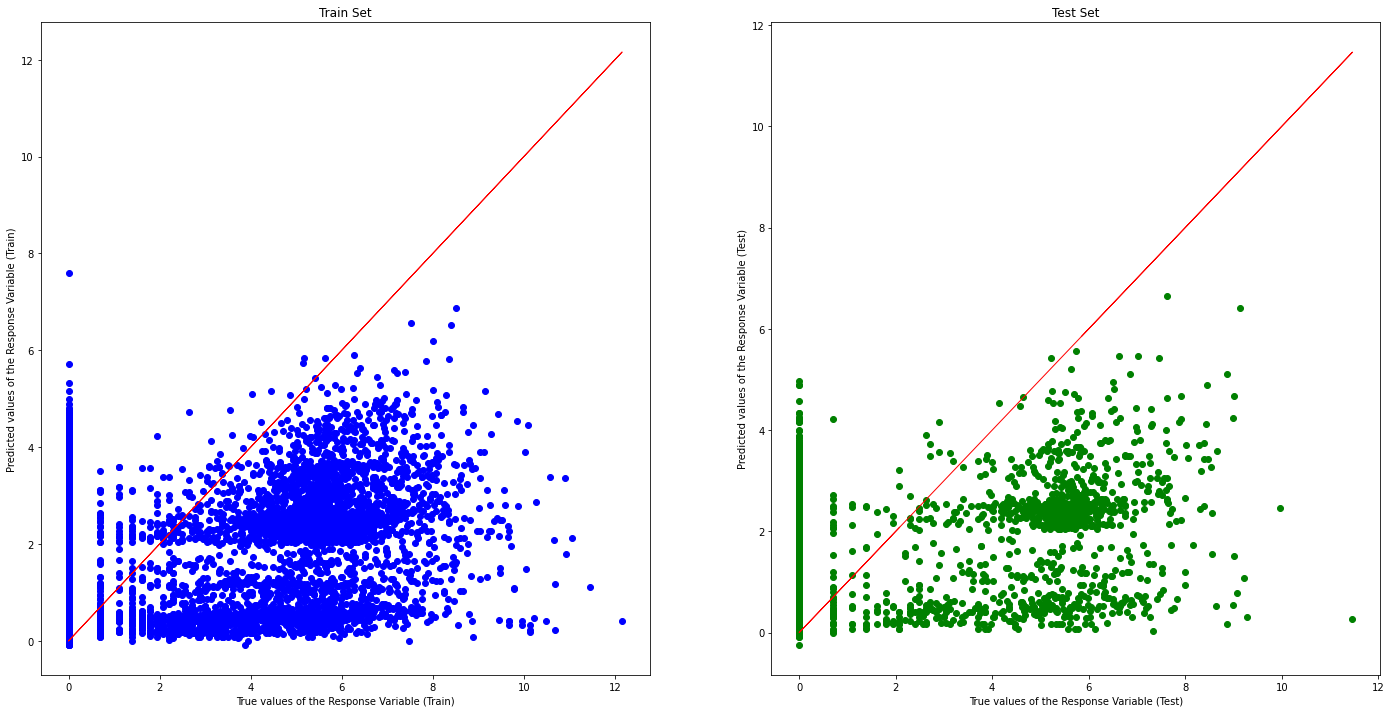

In [42]:
from sklearn.linear_model import LinearRegression
# Training the model
reg = LinearRegression().fit(X_train, y_train)

# Linear Regression Graph
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "green")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

### Check Goodness of Fit of the Model

In [43]:
print("Linear Regression Model\n")
# Intercept & Coefficients
print('Intercept of Regression \t: b = ', reg.intercept_)
print('Coefficients of Regression \t: a = ', reg.coef_)

for i in range(len(reg.coef_)):
    print(features[i+1], " "*(19-len(features[i+1])), ":", reg.coef_[i])

print("\nGoodness of Fit of Model \tTrain Dataset")
print("Var train:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("MSE train: ", mse_train)
print("Real MSE (e^MSE): ", mse_actual(mse_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Var test:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("MSE test: ", mse_test)
print("Real MSE (e^MSE): ", mse_actual(mse_test))


Linear Regression Model

Intercept of Regression 	: b =  0.48884206184699097
Coefficients of Regression 	: a =  [ 2.03824273 -0.08482268  0.1921273   0.01703199  0.70512978  0.09695759
  1.08756625  0.55524813 -0.23912591]
steam_trading_cards  : 2.0382427326375234
cat_sum              : -0.08482267656201853
steam_cloud          : 0.19212729934870498
price                : 0.01703199413946061
multi_player         : 0.7051297824581104
required_age         : 0.09695759128506674
steam_workshop       : 1.0875662514853286
co_op                : 0.5552481299771563
casual               : -0.23912591386994167

Goodness of Fit of Model 	Train Dataset
Var train: 0.22661706447020036
MSE train:  4.027584608358085
Real MSE (e^MSE):  56.12518309664294

Goodness of Fit of Model 	Test Dataset
Var test: 0.22232682244461677
MSE test:  3.945554326026932
Real MSE (e^MSE):  51.70499159225031


**Important** : The Explained Variance (R^2) with normal Linear Regression is low. To try and see if we can improve the score of our model, Gradient Boosting with hyperparameter tuning is applied.

### Creating a Model for average_playtime : GradientBoostingRegressor
`GradientBoostingRegressor` is used to try and improve the accuracy of the model.

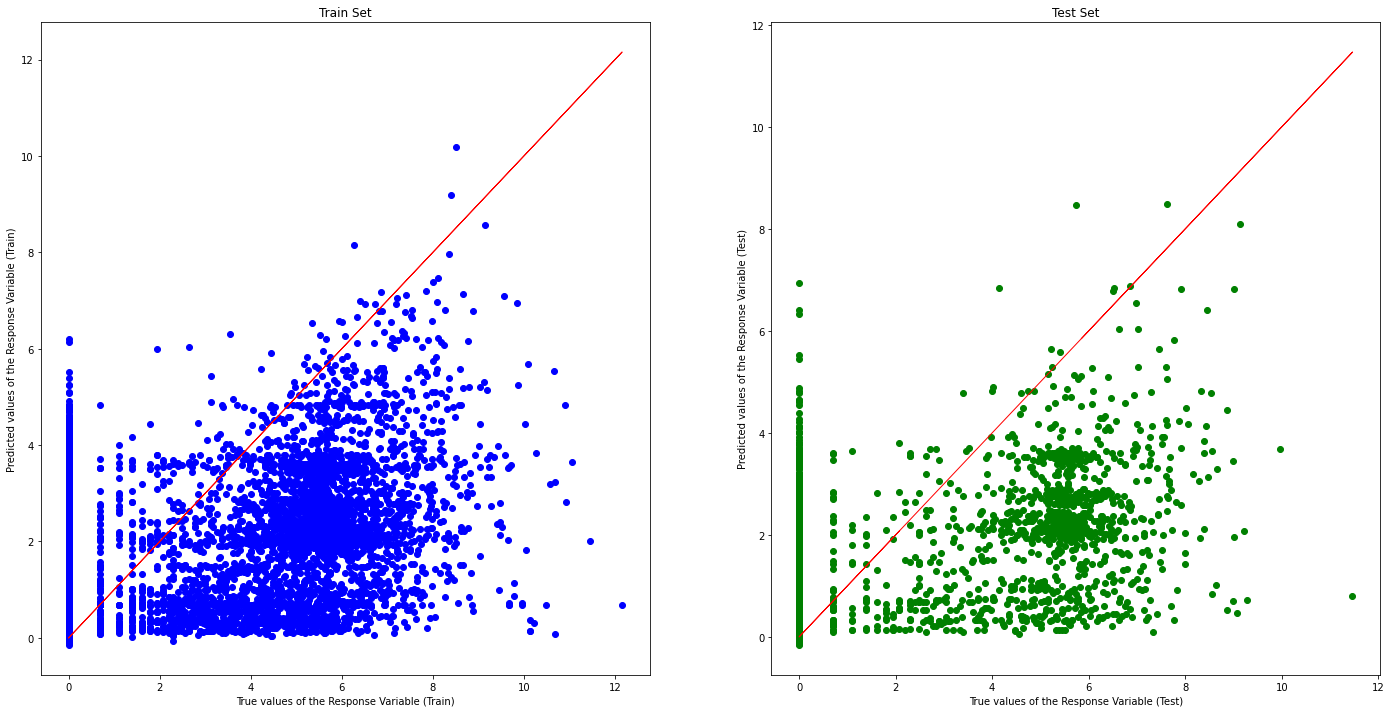

In [44]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)

# Gradient Boost Regression Graph with tuned parameters 
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Train Set")
axes[0].scatter(y_train, reg.predict(X_train), color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].title.set_text("Test Set")
axes[1].scatter(y_test, reg.predict(X_test), color = "green")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()

In [45]:
print("GradientBoostingRegressor Model\n")

print("Goodness of Fit of Model \tTrain Dataset")
print("Var train:", reg.score(X_train, y_train))
train_predict = reg.predict(X_train)
mse_train = mean_sq_err(y_train, train_predict)
print("MSE train: ", mse_train)
print("Real MSE (e^MSE): ", mse_actual(mse_train))
print()

print("Goodness of Fit of Model \tTest Dataset")
print("Var test:", reg.score(X_test, y_test))
test_predict = reg.predict(X_test)
mse_test = mean_sq_err(y_test, test_predict)
print("MSE test: ", mse_test)
print("Real MSE (e^MSE): ", mse_actual(mse_test))


GradientBoostingRegressor Model

Goodness of Fit of Model 	Train Dataset
Var train: 0.2975446767981569
MSE train:  3.6582113695705325
Real MSE (e^MSE):  38.79189641647843

Goodness of Fit of Model 	Test Dataset
Var test: 0.27794538049212747
MSE test:  3.6633714648389395
Real MSE (e^MSE):  38.992583634911725


After using Gradient boost, the Explained Variance (R^2) increased slightly, the MSE of both the model also decreased slightly.   

However, we can further improve the accuracy by using `GridSearchCV` to do Hyperparameter tuning, to better fit our model. 

### Improving the Model: GradientBoostingRegressor
To improve the regressor model, we used KFold cross-validation and Hyperparameter Tuning.

We used `GridSearchCV` for our hyperparameter tuning. `GridSearchCV` works by testing multiple configurations of a model and returning the settings that results in the best validation score.

KFold allows for more training data and validation data as it uses the entire dataset for both training and testing by splitting the dataset into folds, running multiple iterations with a different fold as the test set each time.

<!--As hyper parameter tuning has a small risk of over fitting, we decided to keep a small test set (10%) to see the models final performance.-->


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# As tuning hyperparameter might cause over fitting,
# we decided to split to test and train/validate set.
# we used a smaller test set to have more data for training/validation
# X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.1, random_state=123)

gbr = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid={
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'n_estimators': [50,100],
    'max_depth':[2,3,4]
    }, cv=5, return_train_score=False)

gbr.fit(X_train, y_train)
# clf.cv_results_

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'max_depth': [2, 3, 4], 'n_estimators': [50, 100]})

In [47]:
print("Best hyper-parameters:")
for key in gbr.best_params_:
    print(key, " "*(12-len(key)),":", gbr.best_params_[key])

Best hyper-parameters:
loss          : squared_error
max_depth     : 4
n_estimators  : 100


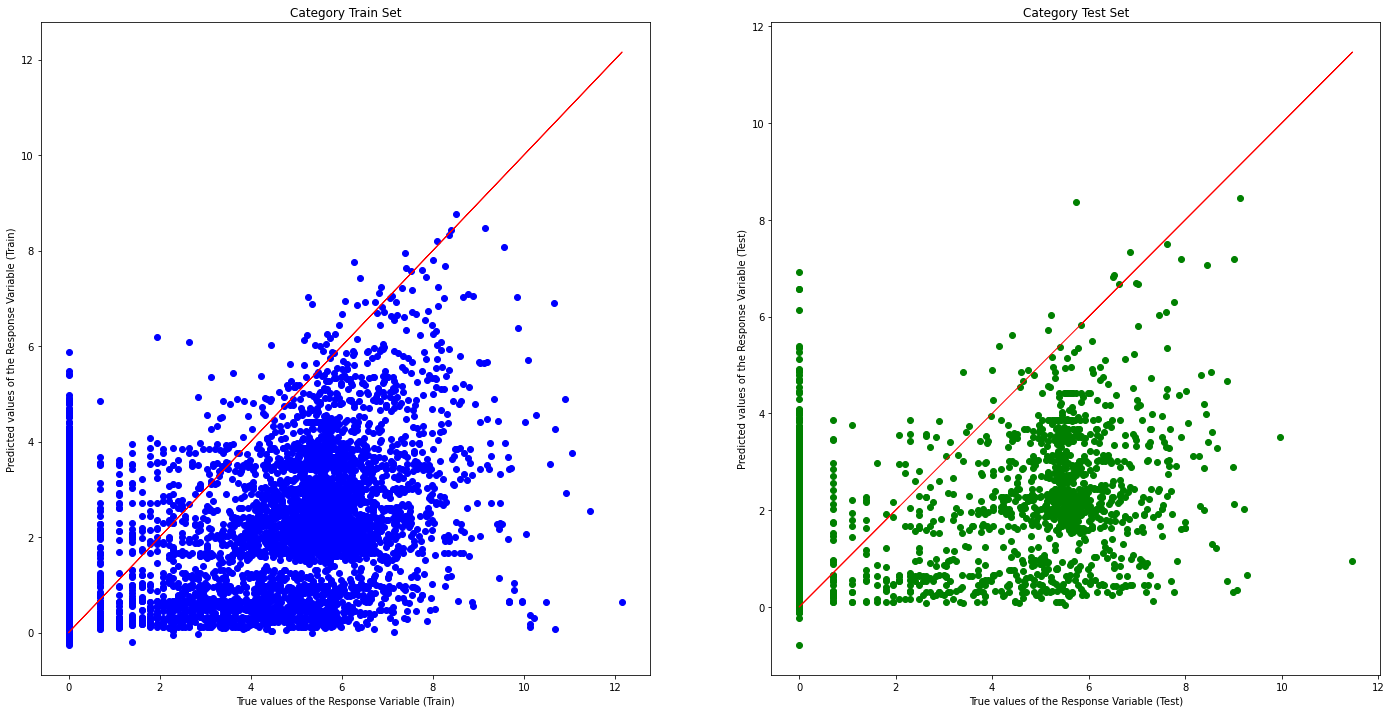

In [48]:
from sklearn.ensemble import GradientBoostingRegressor
# training gradient boost regresion with tuned parameters
gbr_tuned = GradientBoostingRegressor(random_state=0, loss='squared_error', max_depth=4, n_estimators=100)
gbr_tuned.fit(X_train, y_train.values.ravel())

# Gradient Boost Regression Graph with tuned parameters 
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Category Train Set")
axes[0].scatter(y_train, gbr_tuned.predict(X_train), color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].title.set_text("Category Test Set")
axes[1].scatter(y_test, gbr_tuned.predict(X_test), color = "green")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


In [49]:
print("Gradient boost with tuned parameters using gridSearchCV and KFold cross-validation ")
print("Gradient boost var train: ", gbr_tuned.score(X_train, y_train))
mse_train = mean_sq_err(y_train, gbr_tuned.predict(X_train))
print("Gradient boost MSE train: ", mse_train)
print("Real MSE (e^MSE): ", mse_actual(mse_train))
print("")
print("Gradient boost var test: ", gbr_tuned.score(X_test, y_test))
mse_test = mean_sq_err(y_test, gbr_tuned.predict(X_test))
print("Gradient boost MSE test: ", mse_test)
print("Real MSE (e^MSE): ", mse_actual(mse_test))


Gradient boost with tuned parameters using gridSearchCV and KFold cross-validation 
Gradient boost var train:  0.3216556153951896
Gradient boost MSE train:  3.5326476407562266
Real MSE (e^MSE):  34.21443533233521

Gradient boost var test:  0.2861834509228318
Gradient boost MSE test:  3.6215753024354016
Real MSE (e^MSE):  37.396432135951194


With Gradient Boost and hyperparameter tuning, the Explained Variance (R^2) of the model increased from about 20% to 30%. This implies that the categories of the game does not have that huge of an impact on `average_playtime`. We can see which predictor has the most importance below.

<AxesSubplot:>

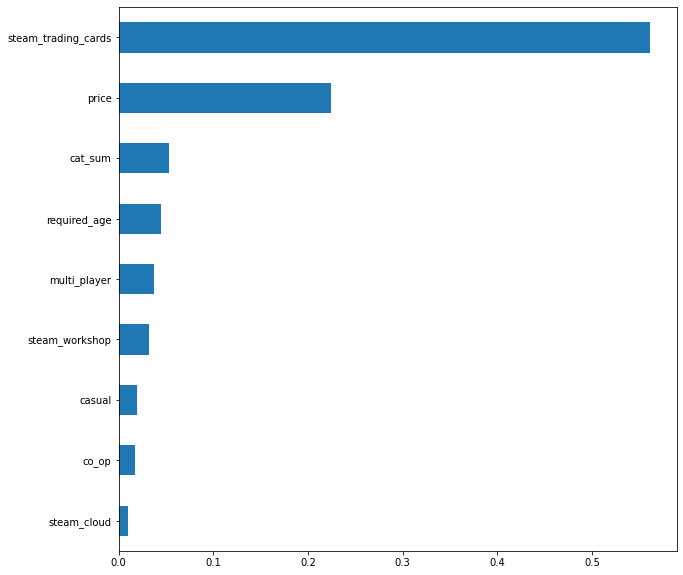

In [50]:
importance_gb = gbr_tuned.feature_importances_
GB_tuned_graph = pd.Series(importance_gb, X_train.columns)
plt.figure(figsize=(10,10))
# plotting feature importance in grid search
GB_tuned_graph.sort_values().plot.barh()

The bar graph above shows that `steam_trading_cards` and `price` have the highest importance in predicting `average_playtime`.   

This implies that the category or genre of the game, like `multi_player`, `steam_workshop`, `casual`, and `co_op` have little to no impact on predicting `average_playtime` at all.   

However, we can try and help developers find out what other variables can predict `average_playtime` accurately, allowing them to target those instead.

### Creating a Model for average_playtime: Other predictors

The predictors chosen are `steam_trading_cards`, `owners`, `overall_reviews`, as these have the highest correlation with `average_playtime`.   

Similarly, `GradientBoostingRegressor` is used with hyperparameter tuning along with cross-validation to best fit our model. 


In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

features = [
    "average_playtime",
    "steam_trading_cards",
    "owners",
    "overall_reviews"
    ]

tempDF = gameDF[features]
tempDF["average_playtime"] = np.log(tempDF.average_playtime+1)
tempDF["owners"] = np.log(tempDF.owners+1)
tempDF["overall_reviews"] = np.log(tempDF.overall_reviews+1)

predictors = tempDF.drop(columns="average_playtime")
response = tempDF.average_playtime

X_train, X_test, y_train, y_test = train_test_split(predictors, response, test_size=0.1, random_state=123)

gbr = GridSearchCV(GradientBoostingRegressor(random_state=0), param_grid={
    'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
    'n_estimators': [10,100],
    'max_depth':[2,3,4]
    }, cv=5, return_train_score=False)

gbr.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=0),
             param_grid={'loss': ['squared_error', 'absolute_error', 'huber',
                                  'quantile'],
                         'max_depth': [2, 3, 4], 'n_estimators': [10, 100]})

In [52]:
print("Best hyper-parameters:")
for key in gbr.best_params_:
    print(key, " "*(12-len(key)),":", gbr.best_params_[key])

Best hyper-parameters:
loss          : squared_error
max_depth     : 3
n_estimators  : 100


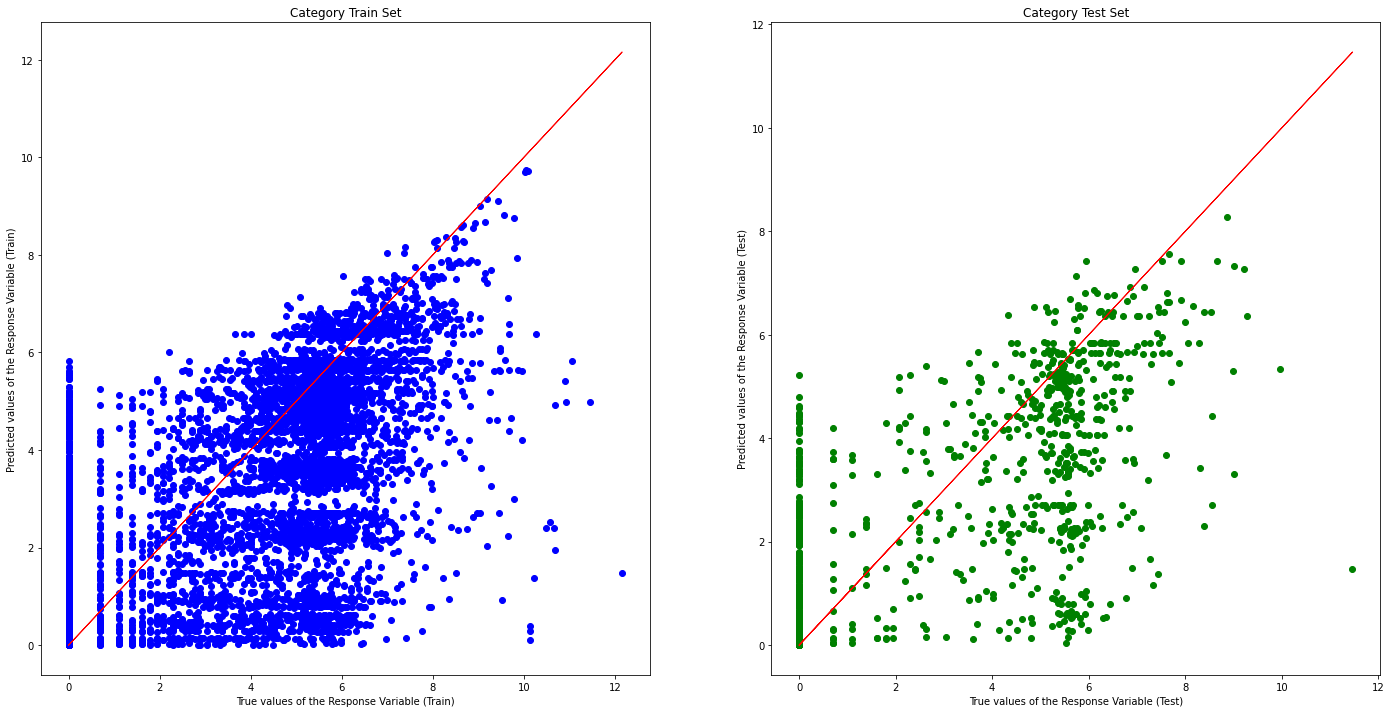

In [53]:
from sklearn.ensemble import GradientBoostingRegressor
# training gradient boost regresion with tuned parameters
gbr_tuned = GradientBoostingRegressor(random_state=0, loss='squared_error', max_depth=4, n_estimators=100)
gbr_tuned.fit(X_train, y_train.values.ravel())

# Gradient Boost Regression Graph with tuned parameters 
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].title.set_text("Category Train Set")
axes[0].scatter(y_train, gbr_tuned.predict(X_train), color = "blue")
axes[0].plot(y_train, y_train, 'r-', linewidth = 1)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")

axes[1].title.set_text("Category Test Set")
axes[1].scatter(y_test, gbr_tuned.predict(X_test), color = "green")
axes[1].plot(y_test, y_test, 'r', linewidth = 1)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")
plt.show()


In [54]:
print("Gradient boost with tuned parameters using gridSearchCV and KFold cross-validation ")
print("Gradient boost var train: ", gbr_tuned.score(X_train, y_train))
mse_train = mean_sq_err(y_train, gbr_tuned.predict(X_train))
print("Gradient boost MSE train: ", mse_train)
print("Real MSE (e^MSE): ", mse_actual(mse_train))
print()
print("Gradient boost var test: ", gbr_tuned.score(X_test, y_test))
mse_test = mean_sq_err(y_test, gbr_tuned.predict(X_test))
print("Gradient boost MSE test: ", mse_test)
print("Real MSE (e^MSE): ", mse_actual(mse_test))


Gradient boost with tuned parameters using gridSearchCV and KFold cross-validation 
Gradient boost var train:  0.656856624739365
Gradient boost MSE train:  1.7776112260137837
Real MSE (e^MSE):  5.9157082369682685

Gradient boost var test:  0.6673708326651153
Gradient boost MSE test:  1.725195385353481
Real MSE (e^MSE):  5.61361774123566


**Important** - The Explained Variance (R^2) of our new model is alot higher, about a 100% increase. Now, we can see which predictor has the highest importance in predicting `average_playtime`.

<AxesSubplot:>

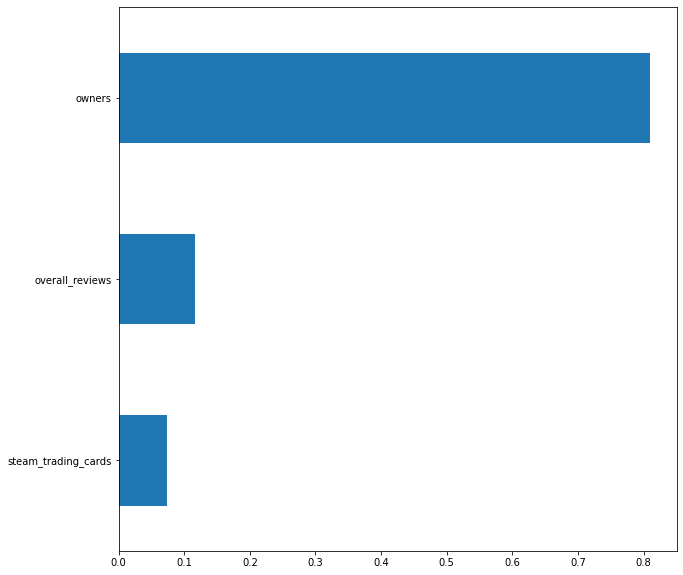

In [55]:
importance_gb = gbr_tuned.feature_importances_
GB_tuned_graph = pd.Series(importance_gb, X_train.columns)
plt.figure(figsize=(10,10))
# plotting feature importance in grid search
GB_tuned_graph.sort_values().plot.barh()

<a id='Conclusion'></a>

## Conclusion
We set off this project to predict the average playtime of a Steam game based on attributes and properties from steam. From our EDA, we can observe that there is a positive correlation between number of reviews, owners and price to a game's playtime. Certain tags such as MMO have a small positive coorelation of 0.04, while tags such as free_to_play have a medium negative coorelation of -0.20 to average playtime. As these are binary tags, they might have small effects on the average playtime.

We then used clustering to gain insights into how different categories affect `average_playtime` when grouped together. However, little correlation was found. This strongly suggested that a game's genre or category  was insufficient to determine it's playtime. However, we still decided to create a model with Machine Learning to see if it can give developers a general idea of how much those features can affect playtime.      

Based on Machine Learning, we were unable to create an accurate model to predict which *genres* and *category* a game should have that can guarantee a high playtime. This implies that our predictors are insufficient and  there are many more factors that affects a game's average playtime, like quality of the game, marketing strategy and promotion of the game, and targeted player base.

However, our Machine Learning model can predict `average_playtime` with a acceptable level of accuracy with other predictors. It is found that a game that a **high number of players own** `owners`, and a game that is **popular** with high amount of `overall_reviews` has a **higher average playtime**.

In conclusion, in order for developers to ensure high playtime for their games, they should focus on ensuring their game is accessible, e.g. cheap/affordable, cross_platform, and popular through marketing and high quality gameplay. Developers can then increase their revenue by selling DLCs or in-game perks by leveraging on the high playerbase.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c84166ab-b520-4ba6-a077-a1b212242f44' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>